In [1]:
# Data processing
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import pickle

# Path configuration for custom module imports  
# -----------------------------------------------------------------------
import sys  
sys.path.append('../')  # Adds the parent directory to the path for custom module imports  

# Ignore warnings  
# -----------------------------------------------------------------------
import warnings  
warnings.filterwarnings("ignore") 

# Custom functions and classes
# -----------------------------------------------------------------------
from src.support_regression import RegressionModels

### Data loading

In [2]:
df = pd.read_csv('../data/output/api_rent_madrid_preprocessed.csv', index_col=0).reset_index(drop=True)
df.head()

,price,size,exterior,rooms,bathrooms,distance,municipality,province,hasLift,numPhotos,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,floor
0,550.0,8.442463,False,4.410093,3,1.048670,657.095509,579.687729,661.431099,1.152172,1.0,0.0,0.0,0.0,0.0,0.0,13.0
1,750.0,-0.221149,True,-0.712507,1,-0.896578,705.594108,693.233618,677.631111,-1.021827,0.0,0.0,0.0,1.0,0.0,0.0,6.0
2,750.0,0.057424,True,0.312013,1,-0.360972,685.520603,693.233618,670.210811,-0.090113,0.0,0.0,0.0,1.0,0.0,0.0,2.0
3,400.0,-0.026148,True,0.312013,2,1.926351,637.579238,693.233618,670.210811,0.634554,0.0,0.0,0.0,0.0,1.0,0.0,5.0
4,450.0,0.586712,False,0.312013,1,1.464429,644.084662,579.687729,677.631111,0.013411,0.0,0.0,0.0,1.0,0.0,0.0,5.0


### Model execution

In this notebook, we will run a decision tree model for our data.

In [6]:
params_tree = {
    'max_depth': range(2, 7),
    'min_samples_split': range(12, 20),
    'min_samples_leaf': range(3, 9),
    'max_leaf_nodes': range(25, 75, 10)
}

In [7]:
tree_model = RegressionModels(df, 'price', frac=0.8, seed=2)
results = tree_model.model_fit("tree", params_tree)
tree_model.get_results()
tree_model.get_metrics("tree").round(2)

,R2,MAE,RMSE
train,0.68,35.41,45.85
test,0.76,33.51,45.21


Best model:
DecisionTreeRegressor(max_depth=4, max_leaf_nodes=25, min_samples_leaf=6,
                      min_samples_split=14)


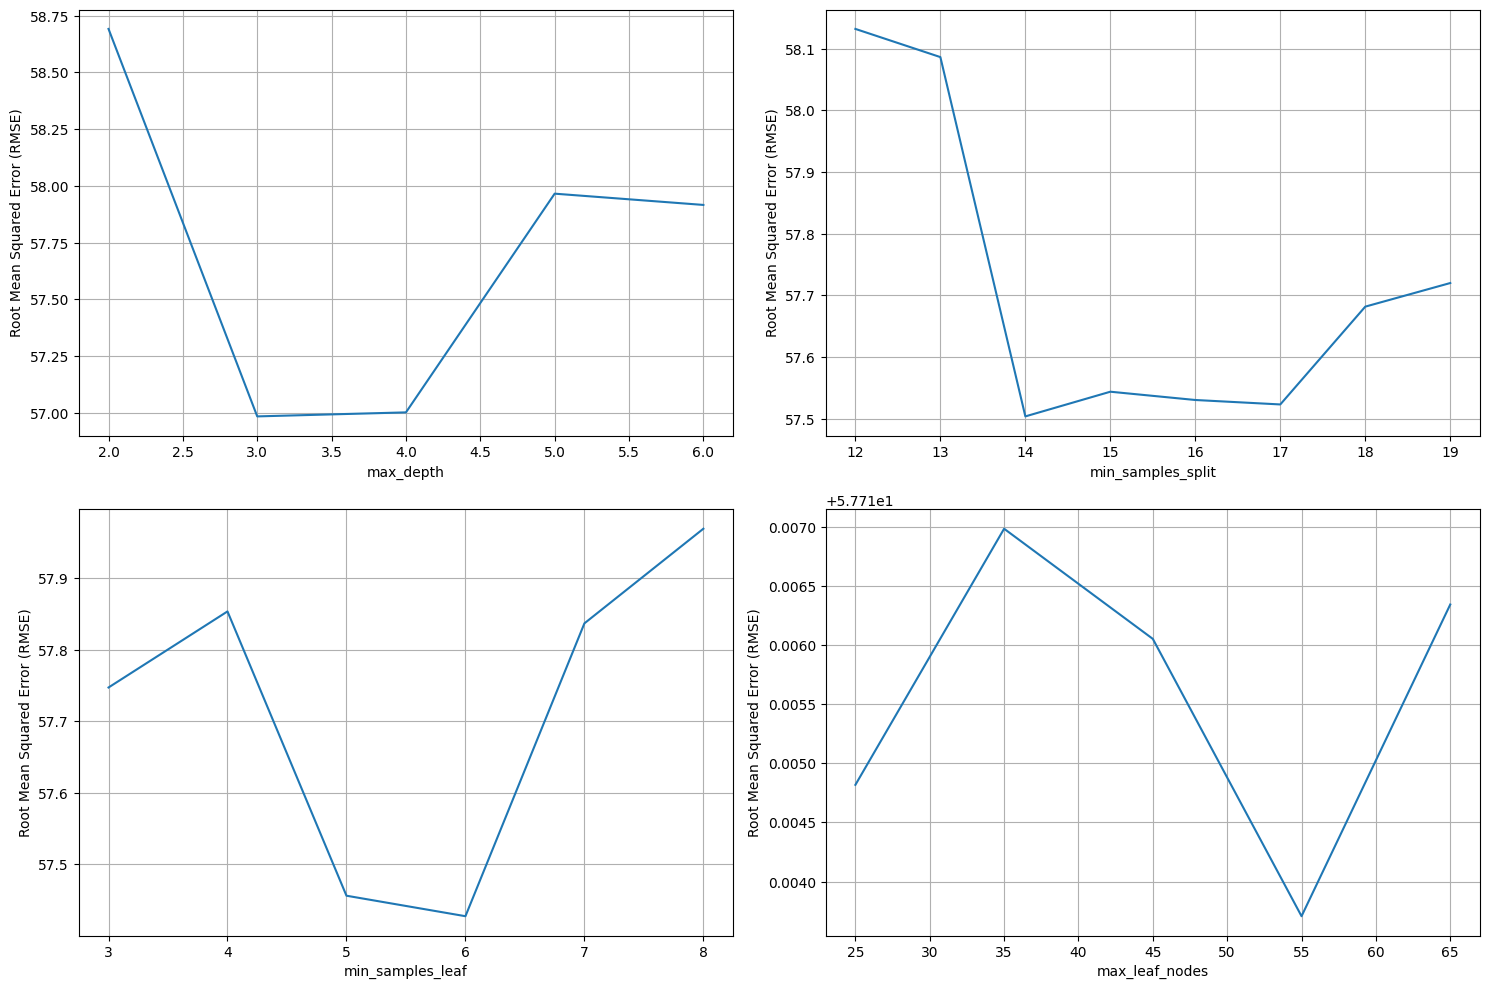

In [8]:
tree_model.plot_best_model(results, 'tree')

After optimizing the hyperparameters, the following combination has been found.

In [11]:
params_tree = {
    'max_depth': [4],
    'min_samples_split': [14],
    'min_samples_leaf': [6],
    'max_leaf_nodes': [55]
}

In [12]:
tree_model = RegressionModels(df, 'price', frac=0.8, seed=2)
results = tree_model.model_fit("tree", params_tree)
tree_model.get_results()
tree_model.get_metrics("tree").round(2)

,R2,MAE,RMSE
train,0.68,35.41,45.85
test,0.76,33.51,45.21


The result is better than in the case of the linear model, with a higher $ R^2 $ and a slightly lower `RMSE`.

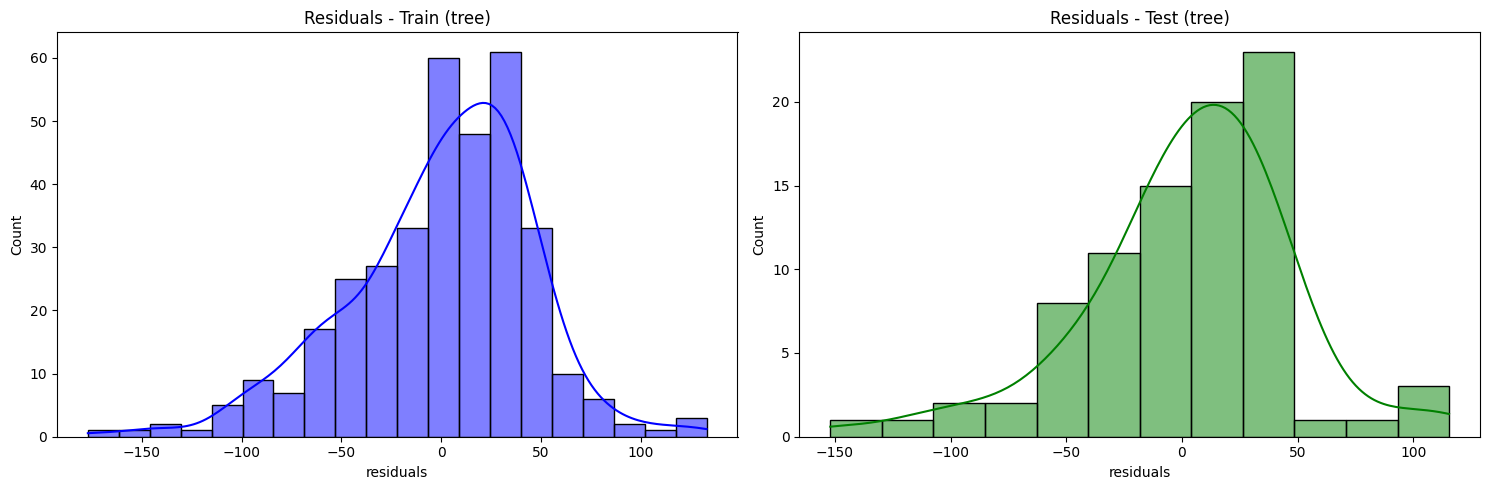

In [13]:
tree_model.plot_residuals('tree')

The residuals are slightly more centered, although they exhibit similar behavior to the linear regression model.

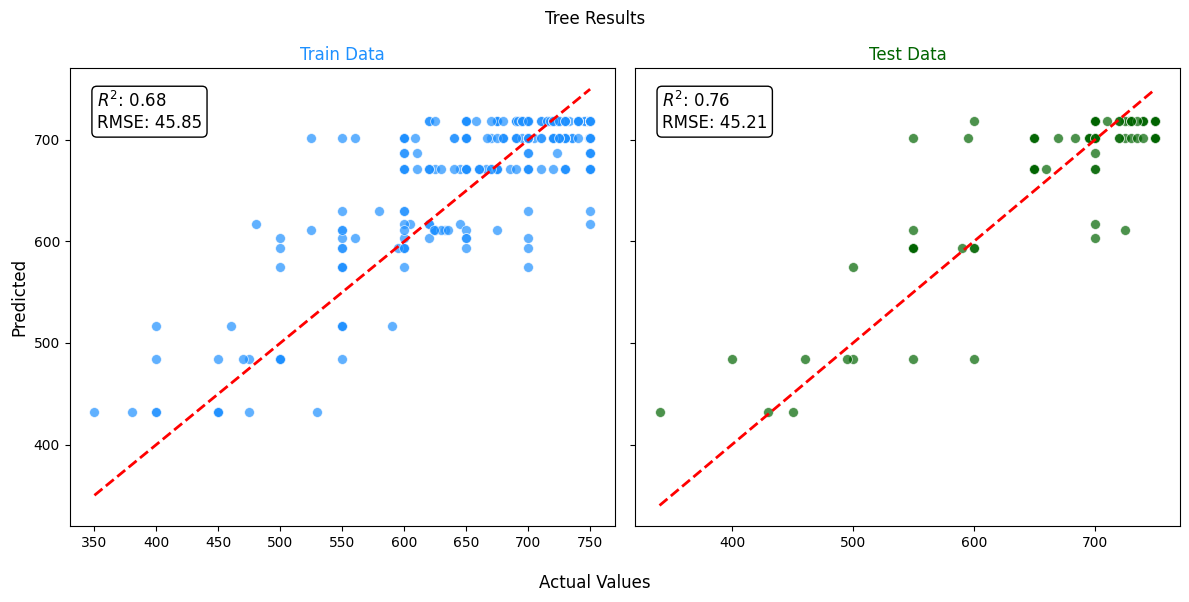

In [21]:
tree_model.plot_actual_vs_prediction('tree')

A data structure can be observed in the predictions, possibly due to the strong influence of a particular column.

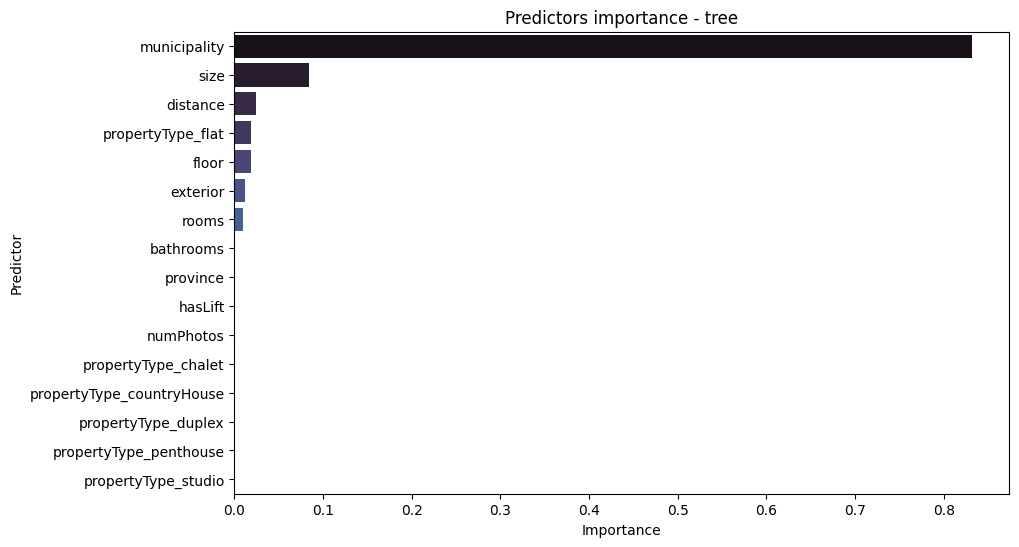

,Predictor,Importance
5,municipality,0.832463
0,size,0.084369
4,distance,0.024483
12,propertyType_flat,0.019164
15,floor,0.018315
1,exterior,0.012004
2,rooms,0.009201
3,bathrooms,0.000000
6,province,0.000000
7,hasLift,0.000000


In [14]:
tree_model.predictors_importance('tree')

The predictor variable with the greatest importance is clearly `municipality`. We also observe that there is a large number of variables whose importance is practically negligible.

Let's try running the model using the dataframe with only the columns with importance greater than `1e-6`.

In [15]:
df2 = df.copy()

In [19]:
df2 = df2[['price', 'municipality', 'size', 'distance', 'propertyType_flat', 'floor', 'exterior', 'rooms']]

In [20]:
tree_model2 = RegressionModels(df2, 'price', frac=0.8, seed=2)
results2 = tree_model2.model_fit("tree", params_tree)
tree_model2.get_results()
tree_model2.get_metrics("tree").round(2)

,R2,MAE,RMSE
train,0.68,35.41,45.85
test,0.76,33.51,45.21


The result is the same, so we will keep the model as it is.

### Model dump

In [22]:
with open('../models/tree_model.pkl', 'wb') as f:
    pickle.dump(tree_model, f)